In [3]:


import numpy as np
import alsvinn
import plot_info
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import matplotlib2tikz
import scipy.integrate

from IPython.core.display import display, HTML



def upscale(d,N):
    """
    Upscales the data to the given resolution
    """
    while d.shape[0] < N:
        d = np.repeat(d,2,0)
    return d



def headline1(name):
    """
    Displays a nice level 1 heading
    """
    display(HTML("<h1>%s</h1>" % name))
    
def headline2(name):
    """
    Displays a nice level 2 heading
    """
    display(HTML("<h2>%s</h2>" % name))
    
    
        
def headline3(name):
    """
    Displays a nice level 2 heading
    """
    display(HTML("<h3>%s</h3>" % name))
    
def estimateConvergenceRates(work, errors):
    """
    Estimates the rate of convergence (error vs work)
    """
    
    # Just be sure we are working with numpy arrays
    work = np.array(work)
    errors = np.array(errors)
    
    # estimate polynomial
    poly = np.polyfit(log(work), log(errors),1)
    
    # Plot
    plt.loglog(work, np.exp(poly[1])*work**[poly[0]],
               '--',label='$\\mathcal{O}(\mathrm{Work}^{%.2f})$' % poly[0])

In [4]:
%%writefile shock_location_mean_convergence.py
# Initial data file
Y = 0.2*X - 0.1
if x <= 0.5 + Y:
    u = 1.0
else:
    u = 0.0

Overwriting shock_location_mean_convergence.py


In [5]:
%%writefile shock_location_mean_convergence.xml
<config>
  <fvm>
    <name>
      shock_location_mean_convergence
    </name>
    <platform>cpu</platform>
    <grid>
      <lowerCorner>0 0 0</lowerCorner>
      <upperCorner>1 0 0</upperCorner>
      <dimension>32 1 1</dimension>
    </grid>
    <boundary>neumann</boundary>
    <flux>godunov</flux>
    <endTime>.2</endTime>
    <equation>burgers</equation>
    <reconstruction>none</reconstruction>
    <cfl>auto</cfl>
    <integrator>auto</integrator>
    <initialData>
      <python>shock_location_mean_convergence.py</python>

      <parameters>
        <parameter>
          <name>X</name>
          <length>1</length>
          <value>0</value>
        </parameter>
      </parameters>
    </initialData>

  </fvm>
  <uq>
    <samples>1024</samples>
    <generator>auto</generator>
    <parameters>
      <parameter>
        <name>X</name>
        <length>1</length>
        <type>uniform</type>
      </parameter>
    </parameters>
    <stats>
      <stat>
        <name>
          meanvar
        </name>
        <numberOfSaves>1</numberOfSaves>
        <writer>
          <type>netcdf</type>
          <basename>shock_location_mean_convergence</basename>
        </writer>
      </stat>
      <stat>
        <name>
          onepointmoment
        </name>
        <p>2</p>
        <numberOfSaves>1</numberOfSaves>
        <writer>
          <type>netcdf</type>
          <basename>shock_location_mean_convergence</basename>
        </writer>
      </stat>
    </stats>

  </uq>
</config>


Overwriting shock_location_mean_convergence.xml


In [6]:
import xml.dom.minidom
import netCDF4
def run(resolution,samples, sample_start=0):
    r = alsvinn.run(base_xml='shock_location_mean_convergence.xml',
                   samples=samples,
                   sampleStart=sample_start,
                   dimension=[int(resolution), 1, 1],
                   uq=True)
    
    stats = ['mean','variance','m2']
    results = {}
    for stat in stats:
        results[stat] = r.get_data('u', timestep=0, statistics=stat)
    return results

def mlmc(resolution):
    L = 5
    
    mean = np.zeros(resolution)
    variance = np.zeros(resolution)
    runtime = 0
    sample_start = 0
    for l in range(1, L):
        samples = 2**(2*(L-l))*16
        runtime += samples*((resolution/2**(L-l))**2 + (resolution/2**(L-l+1))**2)
        result1 = run(resolution/2**(L-l), samples, sample_start=sample_start)
        result2 = run(resolution/2**(L-l+1), samples, sample_start=sample_start)
        r1 = upscale(result1['mean'], resolution)
        r2 = upscale(result2['mean'], resolution)
        
        
        m1 = upscale(result1['m2'], resolution)
        m2 = upscale(result2['m2'], resolution)
        
        mean += (r1-r2)
        
        variance += (m1-m2)
        sample_start += samples
    result= run(resolution/2**L, resolution)
    r = upscale(result['mean'], resolution)
    m = upscale(result['m2'], resolution)
    
    runtime += (resolution/2**L)**2*resolution
    mean += r
    
    variance += m
    
    variance = (variance - mean**2)
    return {'mean' : mean, 'variance':variance}, runtime
        

In [7]:
def plotRate(runtime, error, p):
    poly = np.polyfit(np.log(runtime), np.log(error),1)
    plt.loglog(runtime, exp(poly[1])*runtime**poly[0],
               '--',label='$\\mathcal{O}(\\mathrm{Work}^{%.2f})$' % poly[0],
              color=p[0].get_color())
def convergence(stats, solution, resolutions):
    errors = {}
    runtimeMC = []
    for s in stats:
        errors[s] = []
        
    errorsMlmc = {}
    runtimeMlmc = []
    for s in stats:
        errorsMlmc[s] = []
        
    
    for r in resolutions:
        result = run(r,r)
        x = np.linspace(0,1,r)
        x += (x[1]-x[0])/2
        resultMlmc,runtime = mlmc(r)
        for s in stats:
            exact = solution[s](x)
            errors[s].append(np.sum(abs(exact - result[s]))/r)
            plt.plot(x, exact, '--', label='Exact')
            plt.plot(x, result[s], label='Monte-Carlo')
            plt.xlabel('$x$')
            if s == 'mean':
                plt.ylabel('$\\mathbb{E}(u(\cdot;x, 0.2))$')
            else:
                plt.ylabel('$\\mathrm{Var}(u(\cdot;x, 0.2))$')
                
            
            
            
            errorsMlmc[s].append(sum(abs(exact-resultMlmc[s]))/r)
            
            plt.plot(x, resultMlmc[s], label='MLMC')
            plt.title('%s at $N=%d$' % (s, r))
            plt.legend()
            plot_info.showAndSave('shock_location_%s_%d' % (s,r))
            
        runtimeMC.append(r**3)
        
        
        
      
        runtimeMlmc.append(runtime)
    
    for s in stats:
        p = plt.loglog(runtimeMC, errors[s], '-o', label='Monte-Carlo')
        plotRate(runtimeMC, errors[s], p)
        p = plt.loglog(runtimeMlmc, errorsMlmc[s], '-*', label='MLMC')
        plotRate(runtimeMlmc, errorsMlmc[s], p)
        
        plt.title("Convergence %s" % s)
        plt.xlabel("Work")
        plt.ylabel("Error ($||\\cdot ||_{L^1([0,1])}$)")
        plt.legend()
        plt.gca().set_xscale('log', basex=2)
        plt.gca().set_yscale('log', basey=2)
        plot_info.showAndSave('shock_location_convergence_%s' % s)

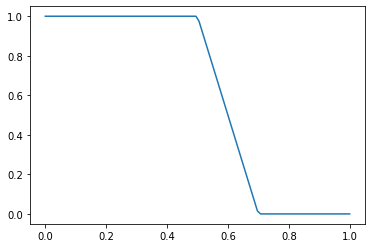

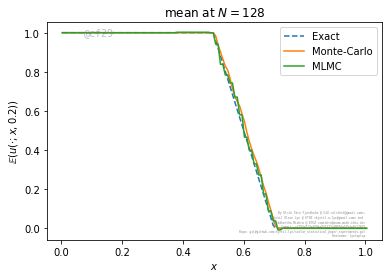

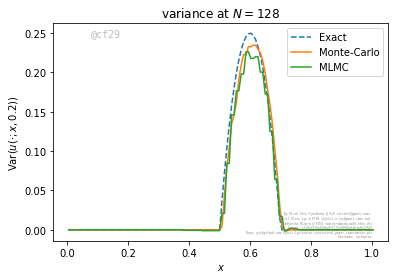

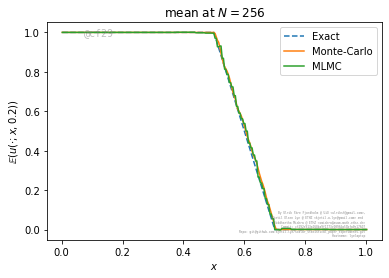

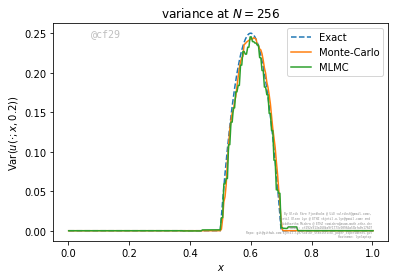

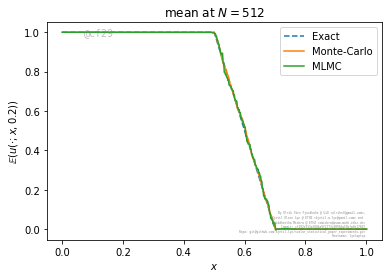

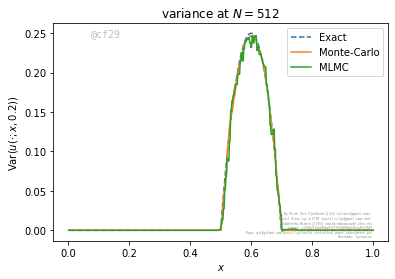

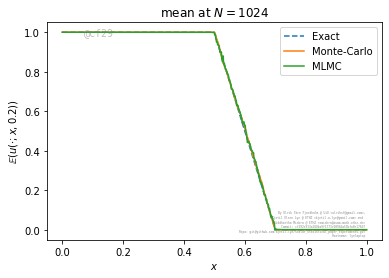

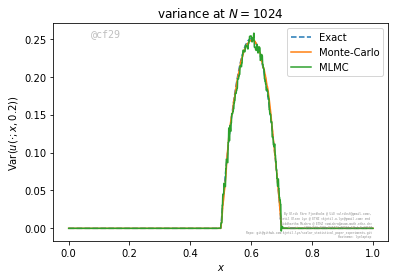

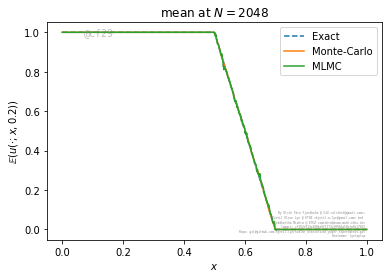

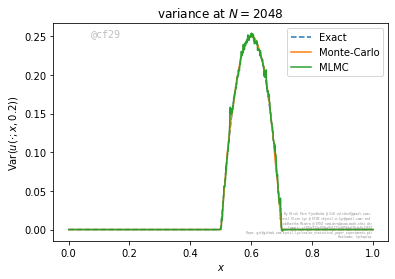

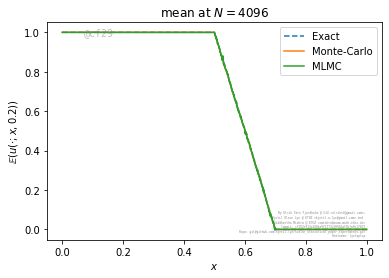

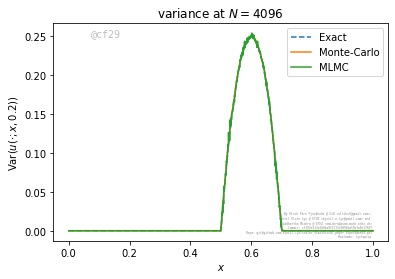

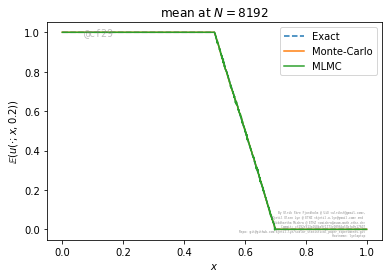

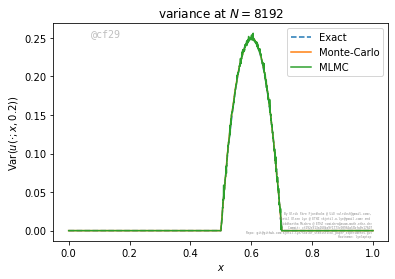

In [ ]:
stats = ['mean','variance']
t=0.2
def exact(xi):
    t=0.2
    sol = np.zeros_like(xi)
    for (n,x) in enumerate(xi):
        sol[n]= 1/0.2*max(0,0.1-max(-0.1,x-0.5-0.5*t))
        
    return sol

exactSolution = {'mean': exact, 'variance': lambda x: exact(x)-exact(x)**2}
x = np.linspace(0,1,100)
plt.plot(x, exactSolution['mean'](x))
plt.show()

convergence(['mean','variance'], exactSolution, [128,256,512,1024,2048,4096, 2*4096, 4*4096])

In [ ]:
import scipy.integrate
def exactU(y,x,t):
    if x < 0.5 + y + 0.5*t:
        return 1
    else:
        return 0
def exactQuad(x,t):
    u = np.zeros_like(x)
    for (n,xi) in enumerate(x):
        
        u[n] = 1/0.2*scipy.integrate.quad(lambda y: exactU(y,xi,t),-0.1,0.1)[0]
    return u

plt.plot(x, exactQuad(x,t), label='quad')
plt.plot(x, exact(x), label='exact')
plt.legend()
plt.show()